# Soft Actor Critic

#### Off Policy 

## Environment

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [-1.4054298e-03  1.4162291e+00 -1.4237092e-01  2.3594956e-01
  1.6353275e-03  3.2249160e-02  0.0000000e+00  0.0000000e+00]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


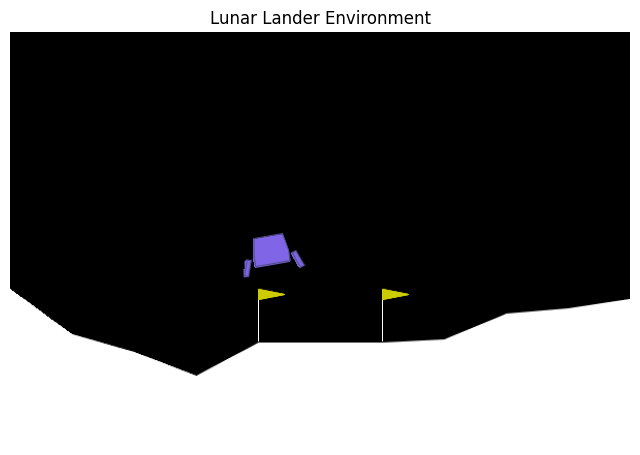

In [3]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(50):
    env.step(action=0)
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Plotting Helper

In [5]:
import matplotlib

In [6]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, show_result=False, save_path=None):
    # Create a horizontal figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0].set_title("Episode Durations")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Duration")
    axes[0].plot(durations_t.numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")

    axes[0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[1].set_title("Rewards")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Reward")
    axes[1].plot(rewards_t.numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")

    axes[1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

## ReplayBuffer

In [7]:
from collections import namedtuple, deque
from typing import List, Deque

# Define the type of the Transition tuple
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


# ReplayMemory class with strong type hints
class ReplayMemory:
    def __init__(self, capacity: int):
        # The deque stores Transition objects
        self.memory: Deque[Transition] = deque([], maxlen=capacity)

    def push(self, state: float, action: int, next_state: float, reward: float, done: bool) -> None:
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward, int(done)))

    def sample(self, batch_size: int) -> List[Transition]:
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Return the current size of the memory"""
        return len(self.memory)

In [8]:
import torch
from torch.optim import Adam
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from models import MLP
from typing import Tuple

import pandas as pd
from datetime import datetime
from numpy.typing import NDArray

In [9]:
torch.manual_seed(1)

## NN Weight Updates

In [10]:
def soft_update(target: nn.Module, source: nn.Module, tau: float) -> None:
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target: nn.Module, source: nn.Module) -> None:
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

## Policy Network

In [11]:
class PolicyNetwork(nn.Module):
    """
    Neural network for policy-based reinforcement learning.

    Architecture:
    - Input layer: Accepts `num_inputs` features representing the state.
    - Hidden layers: Two fully connected layers with 256 units each and ReLU activation for non-linearity.
    - Output layer: Produces `num_outputs`, representing action space size or logits.

    Args:
        num_inputs (int): Number of input features (state size).
        num_outputs (int): Number of output features (action size).

    Methods:
        forward(x): Propagates the input through the network.
    """

    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_inputs).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.net(x)

## Q Network

In [12]:
class QNetwork(nn.Module):
    def __init__(self, num_observations: int, num_actions: int):
        super(QNetwork, self).__init__()
        self.q1 = MLP(input_dim=num_observations + num_actions, output_dim=1)
        self.q2 = MLP(input_dim=num_observations + num_actions, output_dim=1)

    def forward(self, state: torch.Tensor, action: torch.Tensor):
        xu = torch.cat([state, action], 1)

        x1 = self.q1(xu)
        x2 = self.q2(xu)

        return x1, x2

## NN Initializations

In [13]:
# Policy
policy_network = PolicyNetwork(n_observations, n_actions)

# Q Network Q1 and Q2
q_network = QNetwork(n_observations, n_actions)

# Target Q Network Q1_target and Q2_target
q_network_target = QNetwork(n_observations, n_actions)

# Hard update target initially so that Q networks have same weights in the beginning
hard_update(q_network_target, q_network)

## Soft-Actor-Critic

In [ ]:
class SoftActorCriticAgent:
    def __init__(
        self,
        policy_network: nn.Module,
        critic_network: nn.Module,
        target_critic_network: nn.Module,
        discount_factor_gamma: float = 0.99,
        soft_update_rate_tau: float = 0.05,
        exploration_temperature_alpha: float = 0.2,
        normalize_rewards: bool = True,
        device: torch.device = torch.device("cpu"),
        learning_rate: float = 3e-3,
    ) -> None:
        self.discount_factor_gamma = discount_factor_gamma
        self.soft_update_rate_tau = soft_update_rate_tau
        self.exploration_temperature_alpha = exploration_temperature_alpha

        self.policy_network = policy_network
        self.critic_network = critic_network
        self.target_critic_network = target_critic_network

    def sample_stochastic_action_with_log_prob(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """
        Stochastically selects an action and computes its log-probability for discrete SAC.

        Args:
            state (torch.Tensor): The current state.

        Returns:
            Tuple[int, torch.Tensor]:
                - action (int): The chosen action index.
                - log_prob (torch.Tensor): The log-probability of the chosen action.
        """
        action_logits = self.policy_network(state)  # Get logits from the policy network
        action_distribution = Categorical(logits=action_logits)  # Create a categorical distribution
        sampled_action = action_distribution.sample()  # Sample an action
        log_prob = action_distribution.log_prob(sampled_action)  # Compute log-probability
        return int(sampled_action.item()), log_prob

    def sample_greedy_action(self, state: torch.Tensor) -> int:
        """
        Selects the most likely action deterministically for evaluation.

        Args:
            state (torch.Tensor): The current state.

        Returns:
            int: The action index with the highest probability.
        """
        action_logits = self.policy_network(state)  # Get logits from the policy network
        greedy_action = torch.argmax(action_logits).item()  # Select the action with the highest logit
        return int(greedy_action)

    def calculate_policy_loss(self, states: torch.Tensor) -> torch.Tensor:
        """
        Computes the policy loss for the actor in Soft Actor-Critic (SAC) for discrete action spaces.

        Args:
            states (torch.Tensor): Batch of states for which to compute the loss.
            alpha (float): Entropy temperature coefficient.

        Returns:
            torch.Tensor: The mean policy loss for the actor.
        """
        # Get action logits and log probabilities for all actions
        action_logits = self.policy_network(states)
        action_distribution = Categorical(logits=action_logits)
        log_pis = action_distribution.logits  # Log-probabilities for all actions
        action_probs = action_distribution.probs  # Action probabilities

        # Evaluate Q-values for all actions from both critics
        q1_values, q2_values = self.critic_network(states)

        # Take the minimum of the two Q-values for stability
        min_q_values = torch.min(q1_values, q2_values)

        # Compute the weighted loss
        # (α * log_pis - Q(s, a)) weighted by the action probabilities
        weighted_loss = (action_probs * (self.exploration_temperature_alpha * log_pis - min_q_values)).sum(dim=1)
        policy_loss = weighted_loss.mean()

        return policy_loss

    def calculate_q_value_loss(
        self,
        states: torch.Tensor,
        actions: torch.Tensor,
        rewards: torch.Tensor,
        next_states: torch.Tensor,
        dones: torch.Tensor,
        gamma: float,
    ) -> torch.Tensor:
        """
        Computes the Q-value loss for the critics in Soft Actor-Critic (SAC).

        Args:
            states (torch.Tensor): Current states (shape: [batch_size, state_dim]).
            actions (torch.Tensor): Actions taken in the current states (shape: [batch_size]).
            rewards (torch.Tensor): Rewards received after taking the actions (shape: [batch_size]).
            next_states (torch.Tensor): Next states resulting from the actions (shape: [batch_size, state_dim]).
            dones (torch.Tensor): Terminal flags for the episodes (shape: [batch_size]).
            gamma (float): Discount factor for future rewards.

        Returns:
            torch.Tensor: The combined Q-value loss for both Q-networks.
        """
        # Compute current Q-values for the selected actions
        q1_values, q2_values = self.critic_network(states)  # Both Q-network outputs (shape: [batch_size, num_actions])
        q1_current = q1_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Q1 for taken actions
        q2_current = q2_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Q2 for taken actions

        # Compute target Q-values using the Bellman equation
        with torch.no_grad():
            # Compute target policy's probabilities and log probabilities
            next_action_logits = self.policy_network(next_states)
            next_action_distribution = Categorical(logits=next_action_logits)
            next_action_probs = next_action_distribution.probs
            next_action_log_probs = next_action_distribution.logits

            # Compute the target Q-values for next states using the minimum of the critics
            next_q1_values, next_q2_values = self.critic_network(next_states)
            next_q_values = torch.min(next_q1_values, next_q2_values)  # Min Q-values for next state

            # Compute the expected Q-value for the next state
            target_q_values = torch.sum(
                next_action_probs * (next_q_values - self.exploration_temperature_alpha * next_action_log_probs), dim=1
            )
            q_value_target = rewards + gamma * (1 - dones) * target_q_values

        # Compute the Mean Squared Error (MSE) loss for both critics
        qf1_loss = F.mse_loss(q1_current, q_value_target)
        qf2_loss = F.mse_loss(q2_current, q_value_target)

        # Combine the losses
        qf_loss = qf1_loss + qf2_loss

        return qf_loss

    def optimize(
        self,
        replay_buffer: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],
        batch_size: int,
        policy_optimizer: torch.optim.Optimizer,
        critic_optimizer: torch.optim.Optimizer,
    ) -> Tuple[float, float]:
        """
        Performs an optimization step for the policy and critic networks using data from the replay buffer.

        Args:
            replay_buffer (Tuple): A tuple containing states, actions, rewards, next_states, and dones.
            batch_size (int): The batch size for sampling.
            policy_optimizer (torch.optim.Optimizer): Optimizer for the policy network.
            critic_optimizer (torch.optim.Optimizer): Optimizer for the critic network.

        Returns:
            Tuple[float, float]: Policy loss and Q-value loss as Python floats.
        """
        states, actions, rewards, next_states, dones = replay_buffer

        # Sample a batch from the replay buffer
        idx = np.random.choice(len(states), batch_size, replace=False)
        states_batch = states[idx].to(self.device)
        actions_batch = actions[idx].to(self.device)
        rewards_batch = rewards[idx].to(self.device)
        next_states_batch = next_states[idx].to(self.device)
        dones_batch = dones[idx].to(self.device)

        # Calculate Q-value loss
        q_value_loss = self.calculate_q_value_loss(
            states=states_batch,
            actions=actions_batch,
            rewards=rewards_batch,
            next_states=next_states_batch,
            dones=dones_batch,
            gamma=self.discount_factor_gamma,
        )

        # Update critic
        critic_optimizer.zero_grad()
        q_value_loss.backward()
        critic_optimizer.step()

        # Calculate policy loss
        policy_loss = self.calculate_policy_loss(states_batch)

        # Update policy
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Perform soft update for target network
        with torch.no_grad():
            for target_param, param in zip(self.target_critic_network.parameters(), self.critic_network.parameters()):
                target_param.data.copy_(
                    self.soft_update_rate_tau * param.data + (1.0 - self.soft_update_rate_tau) * target_param.data
                )

        return policy_loss.item(), q_value_loss.item()

## Neural Network Initialization

In [ ]:
actor_network = PolicyNetwork(n_observations, n_actions)

critic_network = MLP(input_dim=n_observations, output_dim=1)

## Hyperparameters

In [ ]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

# device = torch.device("cpu")

In [ ]:
learning_rate = 9e-3
discount_factor = 0.99

In [ ]:
actor_critic_agent = ActorCriticAgent(
    policy_network=actor_network,
    critic_network=critic_network,
    discount_factor=discount_factor,
    device=device,
    learning_rate=learning_rate,
)

## Trainer

In [ ]:
def train_policy_on_batch(env: gym.Env, agent: ActorCriticAgent, device: torch.device, batch_size: int = 16) -> dict:
    """
    Collects data from multiple episodes and trains the policy on the combined batch.

    Args:
        env: The environment to interact with (following the OpenAI Gym interface).
        policy: The policy object that defines action selection and optimization.
        device: The device to run computations on (CPU/GPU).
        batch_size: Number of episodes to collect before updating the policy.

    Returns:
        dict: A dictionary of metrics tracking batch performance and training progress.
    """
    global global_track_steps_per_episode, global_track_reward_per_episode

    # Lists to store batch data
    batch_log_probs = []
    batch_rewards = []
    batch_returns = []
    batch_values = []

    total_rewards = []
    total_steps = 0

    for _ in range(batch_size):
        # Reset the environment for a new episode
        state, _ = env.reset()
        episode_log_probs = []
        episode_rewards = []
        episode_values = []

        episode_reward = 0.0
        episode_steps = 0

        while True:
            # Convert state to tensor and send it to the device
            state_tensor = torch.Tensor(state).to(device)

            # Select an action using the policy
            action, log_prob = agent.select_action(state=state_tensor)

            _, value_pred = agent.actor_critic(state_tensor)

            # Take the selected action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)

            episode_steps += 1

            # Store log-probability and reward
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            episode_values.append(value_pred)

            # Update cumulative reward and state
            episode_reward += reward
            state = next_state
            total_steps += 1

            # Break if the episode ends
            if terminated or truncated:
                break

        global_track_steps_per_episode.append(episode_steps)
        global_track_reward_per_episode.append(episode_reward)

        plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode)

        # Store episode data into batch data
        total_rewards.append(episode_reward)
        batch_log_probs.extend(episode_log_probs)
        batch_rewards.extend(episode_rewards)
        batch_values.extend(episode_values)

        # Compute discounted returns for the episode and store them
        episode_returns = agent.compute_discounted_returns(torch.Tensor(episode_rewards))
        batch_returns.extend(episode_returns)

    # Convert batch data to tensors
    batch_log_probs_tensor = torch.stack(batch_log_probs).to(device)
    batch_returns_tensor = torch.Tensor(batch_returns).to(device)
    batch_values_tensor = torch.stack(batch_values).to(device)

    # Optimize the policy
    policy_loss, critic_loss = agent.optimize(batch_log_probs_tensor, batch_returns_tensor, batch_values_tensor)

    # Return metrics to track training progress
    metrics = {
        "batch_reward": sum(total_rewards) / batch_size,  # Average reward per episode
        "total_steps": total_steps // batch_size,
        "policy_loss": policy_loss,
        "critic_loss": critic_loss,
    }

    return metrics

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
def train_vpg_policy(
    max_episodes: int = 500, reward_threshold: float = 200.0, rolling_window: int = 50, batch_size: int = 16
):
    rewards_history = []
    loss_history = []
    steps_history = []

    best_average_reward = 0

    for episode in range(1, max_episodes + 1):
        metrics = train_policy_on_batch(env, actor_critic_agent, device, batch_size)

        # Collect metrics
        rewards_history.append(metrics["batch_reward"])
        loss_history.append(metrics["policy_loss"])
        steps_history.append(metrics["total_steps"])

        # Print metrics every 50 episodes
        avg_reward = np.mean(rewards_history[-50:])

        if episode % 5 == 0:
            print(
                f"Episode {episode}: Average Reward: {avg_reward:.2f}, "
                f"Loss: {metrics['policy_loss']:.4f}, Steps: {metrics['total_steps']}"
            )

        # Convergence condition: Check if the rolling average exceeds the reward threshold
        if len(rewards_history) >= rolling_window:
            avg_rolling_reward = np.mean(rewards_history[-rolling_window:])
            if avg_rolling_reward >= reward_threshold:
                print(
                    f"Environment solved in {episode} episodes! "
                    f"Average reward over the last {rolling_window} episodes: {avg_rolling_reward:.2f}"
                )
                break
        if avg_reward >= best_average_reward:
            best_average_reward = avg_reward

            # Create a filename that includes both the steps_done and timestamp
            filename = f"output/actor_critic_policy_network_lunar_lander_v3_bs_{batch_size}_{timestamp}.pth"

            # Save the policy network with the dynamically generated filename
            torch.save(policy.policy_network.state_dict(), filename)

            print(f"Episode: {episode}, Average reward: {avg_reward}. Model saved as: {filename}")

    env.close()

    return rewards_history, loss_history, steps_history

In [ ]:
max_episodes = 100
reward_threshold = 200.0
batch_size = 16

global_track_steps_per_episode = []
global_track_reward_per_episode = []

rewards_history, loss_history, steps_history = train_vpg_policy(
    max_episodes=max_episodes, reward_threshold=reward_threshold, batch_size=batch_size
)